# The motivation

There are some instances where you would like to compare two images with one another-- but you can't directly compare the two images, because the space in which they are represented are different. For instance, one image may have a hgiher pixel density than another, or an image may be rotated differently, or number of reasons. Let's look at a few use cases I've run into over the years. You can add your own:

* I have low resolution videos of a cell stain using a fluorescent microscope that I would like to align with still images of a different cell stain taken using a higher-resolution image taken using a confocal microscope.
* I have a stack of images of brain slices, all taken at different depths within the brain, and I would like to align them.
* I have MRI images from several patients of different ages, and I would like to compare different structures across patients.

How would you go about doing this? Before being able to explain these, we need to introduce motion models.

## Motion Models

Motion models allow us to describe the relationship between an image and a **warping** of that image. We are going to start with a few basic motion models.

In a **translation** transform, the image is shifted by (x,y) (two parameters).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import warp, SimilarityTransform
from skimage import data

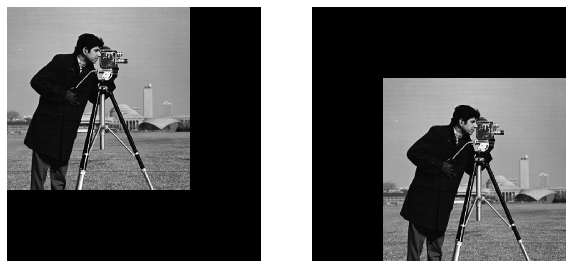

In [2]:
im = np.pad(data.camera(), (0, 200))
tform = SimilarityTransform(translation=(-200, -200))
warped = warp(im, tform)

fig, axes = plt.subplots(ncols=2, figsize=(10, 6))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(warped, cmap='gray')

In a **Euclidean** transform, the imge is rotated by angle $\theta$ and shifted by (x,y) (three parameters).

In [28]:
tform = SimilarityTransform(rotation=np.pi/4, translation=(300, -400))
warped = warp(im, tform)

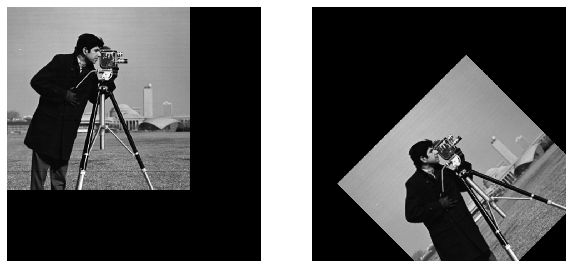

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 6))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(warped, cmap='gray')

In an **affine transform**, the image is rotated by $\theta$, shifted by (x,y), scaled by (*a*, *b*), and sheared by $\phi$ (six parameters). In an affine transformation, parallel lines remain parallel, but lines meeting at right angles no longer do so.

In [2]:
from skimage.transform import AffineTransform

In [61]:
tform = AffineTransform(rotation=np.pi/8, translation=(100,-100), scale=(1.5, 1), shear=np.pi/8)
warped = warp(im, tform)

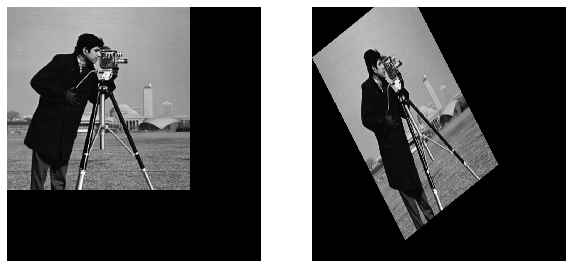

In [62]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 6))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(warped, cmap='gray')

A **homography** transform accounts for 3D effects-- you can have bending in and out of the plane of interest. There are eight parameters total. A square transformed via a homography transform can become any quadrilateral.

In [3]:
from skimage.transform import ProjectiveTransform

In [15]:
(x, y) = (100, -100)
theta = np.pi/8
(sx, sy) = (1.5, 1)
shear = np.pi/8
(c0,c1) = (0.0000, 0.0005)

mtx = np.array([[sx*np.cos(theta), -sy*np.sin(theta+shear), x],[sx*np.sin(theta), sy*np.cos(theta+shear), y],[c0,c1,1]])

tform = ProjectiveTransform(matrix=mtx)
warped = warp(im, tform)

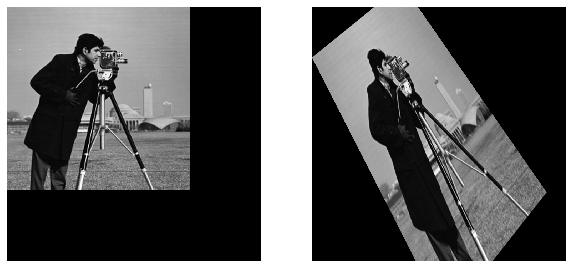

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 6))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(warped, cmap='gray')

This may seem familiar, as you have probably manipulated images in a similar way in Powerpoint or other programs. This just formalized it mathematically.

You may also notice that you can represent any homology transformation (and therefore affine, Euclidean, and translation) as a matrix. This is a handly tool!

The nice thing about matrix representation is that you can perform the inverse transform as well:

In [17]:
mtx_inv = np.linalg.inv(mtx)
tform = ProjectiveTransform(matrix=mtx_inv)
warped_inv = warp(warped, tform)

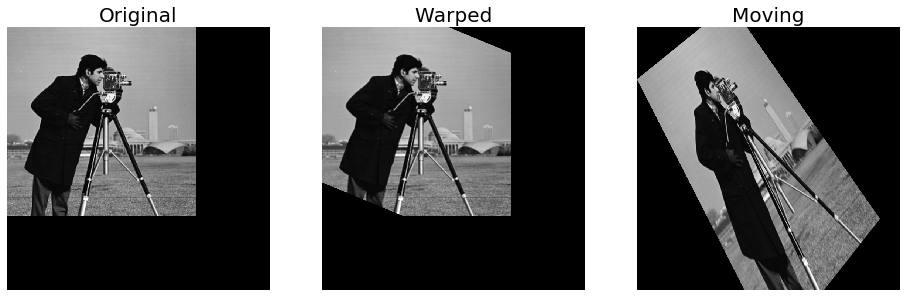

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 6))
titles = ['Original', 'Warped', 'Moving']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=20)
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(warped_inv, cmap='gray')
axes[2].imshow(warped, cmap='gray')

## Rigid Image Registration

This begs the question though: if we didn't directly manipulate the image, how are we supposed to have the correct transform? Luckily, there are a couple package out there that do it for you. One common method for these rigid motion models is specifying points that are equivalent in each space. A minimum of four points is needed to transform the image.

Unfortunately, there isn't a single central package in Python for doing image transforms like this. There are some tools in OpenCV for doing this so we'll go with that. You can, however, see the math [here](https://math.stackexchange.com/questions/494238/how-to-compute-homography-matrix-h-from-corresponding-points-2d-2d-planar-homog)

In [89]:
%matplotlib qt

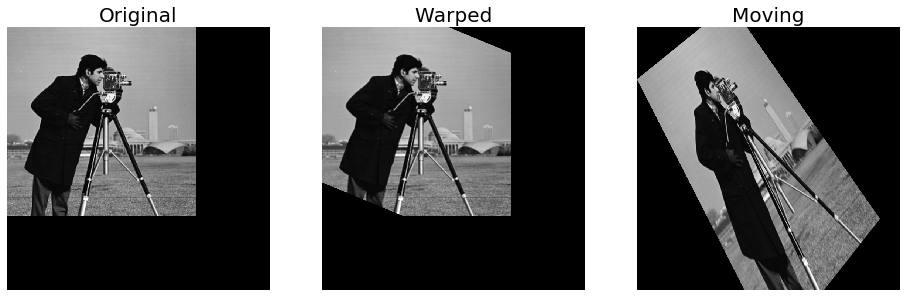

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 6))
titles = ['Original', 'Warped', 'Moving']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=20)
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(warped_inv, cmap='gray')
axes[2].imshow(warped, cmap='gray')

I found the four equivalent points to be:

In [7]:
pts_src = np.array([[0,0],[512,512],[338,148],[407,512]])
pts_dst = np.array([[0,135],[659,518],[269,150],[606,582]])

In [4]:
import cv2

In [20]:
mtx_inv, status = cv2.findHomography(pts_src, pts_dst)
tform = ProjectiveTransform(matrix=mtx_inv)
warped_inv = warp(warped, tform)

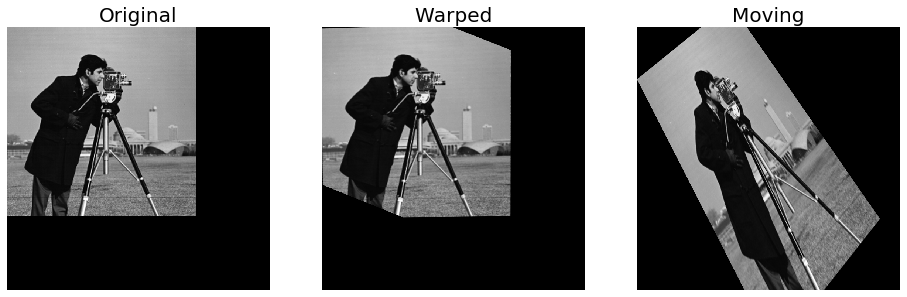

In [21]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 6))
titles = ['Original', 'Warped', 'Moving']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=20)
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(warped_inv, cmap='gray')
axes[2].imshow(warped, cmap='gray')

Even if we were slightly off in estimating the points, we still were able to nearly reproduce the transform based on the inverse matrix. Neat!

Try taking a picture of a flat object at different angles, and see if you can use these functions to match them up using the above functions.

This method still has some disadvantages -- it requires some user input. There are some methods that can automatically find the transform for you without have to test equivalent points. These are feature-based methods that seek for similar features in the original and warped images. I haven't found a package that can handle affine transformations or homography transformations, but the `imreg_dft` package can handle translation, rotation, and scale by examining features in the Fourier space of both images. The only inputs you need are the two images to be compared.

In [11]:
from imreg_dft import imreg

In [30]:
(x, y) = (-200, -400)
theta = np.pi/8
(sx, sy) = (1.5, 1.5)
shear = 0
(c0,c1) = (0.0000, 0.0000)

mtx = np.array([[sx*np.cos(theta), -sy*np.sin(theta+shear), x],[sx*np.sin(theta), sy*np.cos(theta+shear), y],[c0,c1,1]])

tform = ProjectiveTransform(matrix=mtx)
warped = warp(im, tform)

In [31]:
output = imreg.similarity(im, warped)

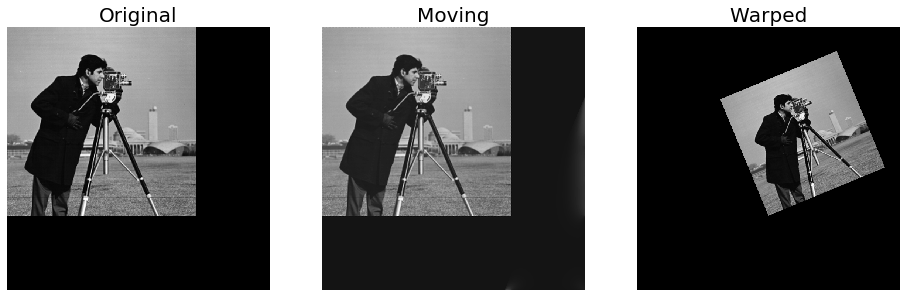

In [32]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 6))
titles = ['Original', 'Moving', 'Warped']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=20)
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(output['timg'], cmap='gray')
axes[2].imshow(warped, cmap='gray')

## Non-Rigid Image Registration

Rigid registration techniques are just the beginning, and most likely a homography transform isn't going to cut it for some of the manipulations you'd like to try. For instance, the motion models we've looked at so far couldn't deal with bends in 3D space (think of curving a piece of paper). More complex motion models will be necessary to capture, say, changes in brain structure between patients.

Homography transforms deal in straight lines. Diffeomorphic transforms can deal with curved lines in space, as long as the curves are differentiable. We're going to take a look at the package for diffeomorphic image registration `dipy`. The functions available in `dipy` assume you have already performed relevant rigid registration-- it won't rotate, translate, or scale for you.

Let's try this introductory example from `dipy` when we seek to make the letter C onto a circle. This clearly will require more than just rigid transformations. Notice, though, that the initial shapes already basically align. If this isn't already done, you would have to achieve that first with rigid transformations.

In [2]:
from dipy.data import get_fnames
from dipy.viz import regtools

C:\Users\koolk\Anaconda3\lib\site-packages\dipy\viz\__init__.py:22: UserWarning: You do not have FURY installed. Some visualization functions might not work for you. For installation instructions, please visit: https://fury.gl/
  "You do not have FURY installed. "


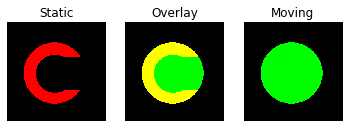

In [15]:
fname_moving = get_fnames('reg_o')
fname_static = get_fnames('reg_c')

moving = np.load(fname_moving)
static = np.load(fname_static)

ims = regtools.overlay_images(static, moving, "Static", "Overlay", "Moving")

The diffeomorphic registration functions in `dipy` seek to minimize a cost function by compared the static image and the warped version of the moving image. You can actually specify the cost function, which we will do here. We will use the Sum of Squared Differences (SSD) for this example.

In [8]:
from dipy.align.metrics import SSDMetric

In [9]:
dim = static.ndim
metric = SSDMetric(dim)

Now we will actually perform the registration using the Symmetric Doffeomorphic Registration function. The alignment takes place on multiple levels of resolution, and we specify those here. 0 corresponds to the finest level of resolution. If you care about alignment of fine details, you should specify lower numbers.

In [10]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration

In [12]:
level_iters = [200, 100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50)
mapping = sdr.optimize(static, moving)

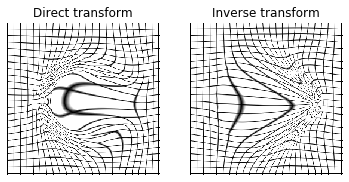

In [14]:
im_maps = regtools.plot_2d_diffeomorphic_map(mapping, 10)

Now let's apply the diffeomorphic transformation to the moving image, and see what we get:

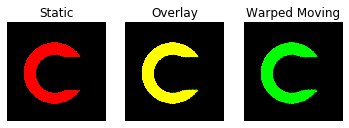

In [16]:
warped_moving = mapping.transform(moving, 'linear')
_ = regtools.overlay_images(static, warped_moving, "Static", "Overlay", "Warped Moving")

What happens if I change the level of detail at which the mapping occurs?

In [47]:
level_iters = [200, 100, 50, 25]
warped_moving = np.zeros((static.shape[0], static.shape[1], 5))
warped_moving[:,:,0] = moving
for i in range(1,5):
    sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=i)
    mapping = sdr.optimize(static, moving)
    warped_moving[:,:,i] = mapping.transform(moving, 'linear')
    
    print(i)

1
2
3
4


In [48]:
from ipywidgets import interactive

In [53]:
def f(i):
    ii = int(i)
    plt.figure(2)
    plt.imshow(warped_moving[:,:,ii], cmap='gray')
    plt.axis('off')
    
interactive_plot = interactive(f, i=(0,4,1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=2, description='i', max=4), Output(layout=Layout(height='350px'))), _dom…

In [ ]:
war